# DESeq2 analysis

Load DESeq2 and the data to be analyzed

In [18]:
# load DESeq2
suppressPackageStartupMessages(require(DESeq2))

#load additional packages used for result exploration:
library("ggplot2")
library("RColorBrewer")

# because DESeq2 works with matrices and uses row names as identifies we load our data accordingly

counts <- read.csv('/home/ucsd-train40/cmm262/deseq2/tardbp_counts_for_deseq2.csv',
                  header=TRUE, row.names=1)
head(counts)

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
ENSG00000227232.4,61,92,69,58
ENSG00000237683.5,23,21,17,28
ENSG00000239906.1,11,2,5,7
ENSG00000241860.2,26,32,35,35
ENSG00000228463.4,77,69,63,66
ENSG00000237094.7,38,44,45,41


In [15]:
# we also need our condition identifiers so DESeq2 know what to compare against what
col.data <- read.csv('/home/ucsd-train40/cmm262/deseq2/tardbp_conditions_for_deseq2.csv',
                  header=TRUE, row.names=1)

head(col.data)

,condition
NT_shRNA_hepg2_Rep1,control
NT_shRNA_hepg2_Rep2,control
TARDBP_shRNA_hepg2_Rep1,knockdown
TARDBP_shRNA_hepg2_Rep2,knockdown


Using our featurecounts processed data we don't have to do any data normalization since DESeq2 will do that for us. Instead we only have to format our data so DESeq2 can analyze it. More analysis details can be found in the [example page](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) of DESeq2.


First, we will define experimental parameters. If using a counts matrix, we will use the following function, where countData is equal to our counts matrix ("counts"), colData is equal to our conditions, and design accounts for how we wish to model our effect (in this case, by the "condition" or treatment with a specific shRNA). The factor variable, in this case condition, needs to be columns of coldata:

In [16]:
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col.data,
                              design = ~ condition)

We then execute DESeq on our dataset:

In [7]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [10]:
res <- results(dds)

# save data to your directory
write.csv(as.data.frame(res), file="/home/ucsd-train40/projects/tardbp_shrna/deseq2/tardbp_deseq2_results.csv")

In [11]:
summary(res)


out of 16582 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 3322, 20% 
LFC < 0 (down)   : 3598, 22% 
outliers [1]     : 0, 0% 
low counts [2]   : 322, 1.9% 
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
res.df <- as.data.frame(res)
dim(res.df)
head(res.df)

[1] 16582     6

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000227232.4,69.041623,0.02926717,0.3410696,0.08580996,0.9316175,0.9638649
ENSG00000237683.5,22.458930,0.32578973,0.5874452,0.55458740,0.5791769,0.7263567
ENSG00000239906.1,6.378754,0.13445854,1.1359131,0.11837044,0.9057741,0.9494512
ENSG00000241860.2,32.307452,0.56551663,0.4779151,1.18329943,0.2366905,0.3917037
ENSG00000228463.4,68.649304,0.10658663,0.3384014,0.31497105,0.7527836,0.8519706
ENSG00000237094.7,42.101265,0.35962020,0.4191233,0.85802969,0.3908761,0.5588854


Taken directly from the documentation:
results() extracts a result table from a DESeq analysis giving base means across samples, log2 fold
changes, standard errors, test statistics, p-values and adjusted p-values

The function plotMA allows us to plot the log2 fold changes over the mean of normalized counts for all the samples in dds. Points are colored red if the adjusted p value (alpha) is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down. The window can be widened using the ylim argument

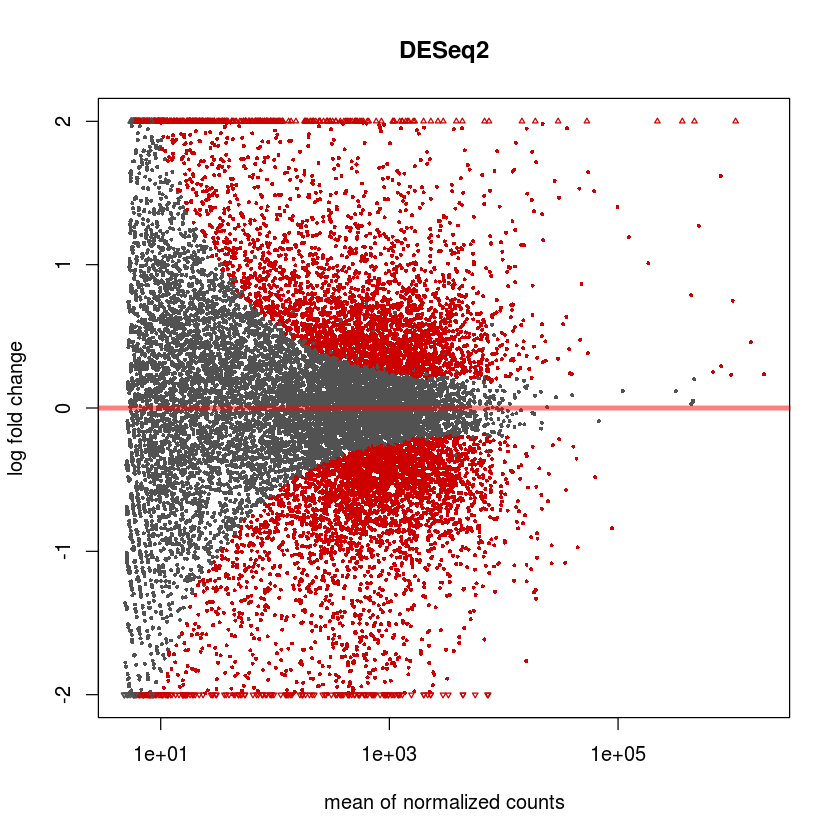

In [13]:
plotMA(res, main="DESeq2", ylim=c(-2,2))


We can also get a more stringent view of our differentially expressed genes by rerunning result on dds with an additional argument alpha. This allows us to be more discerning with our adjusted p value threshold, in this case allowing us to decrease the cutoff to alpha=0.05

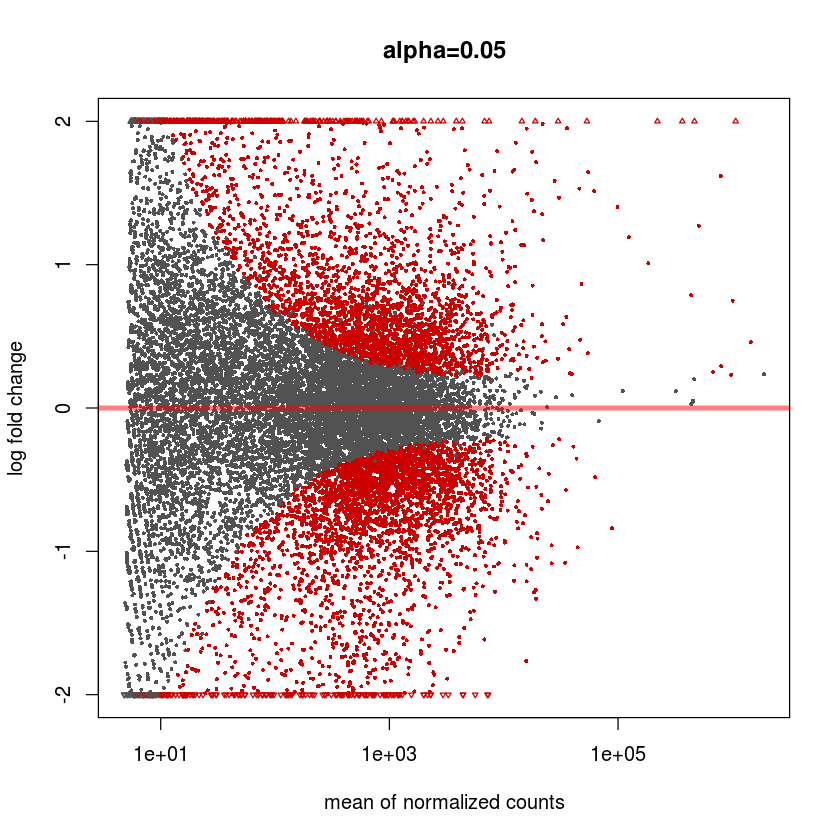

In [14]:
res05 <- results(dds, alpha=0.05)

plotMA(res05, main="alpha=0.05", ylim=c(-2,2))


Let's graph our individual samples using Principle Component Analysis (PCA). This allows us to assess overall variance within our experiment by defining principal components. This plot shows our samples in a 2D plane spanned by their first two principal components. This is useful for visualizing the overall effect of experimental covariates, in this case shRNA treatment, as well as batch effects that may confound findings. For a more thorough explanation of PCA, please refer to this [notebook](https://github.com/biom262/biom262-2018/blob/master/Module1_Unix_RNASeq/Tutorials/Intro_to_PCA.ipynb) in the Tutorials folder.

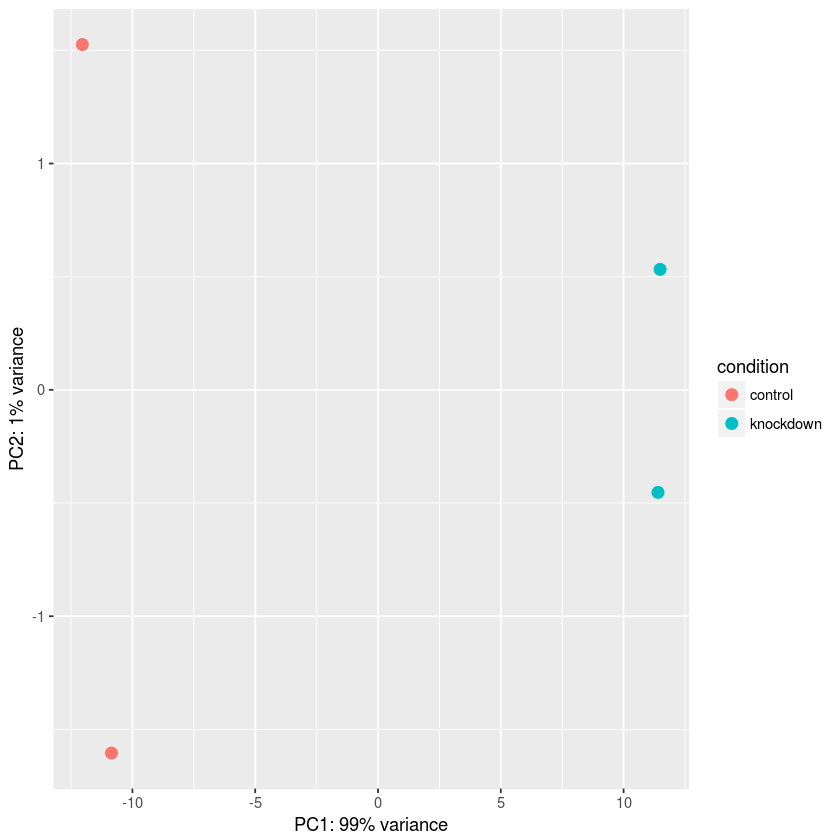

In [20]:
# applying regularized log transformation
rld <- rlog(dds)

data <- plotPCA(rld, intgroup="condition", returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))
ggplot(data, aes(PC1, PC2, color=condition)) +
    geom_point(size=3) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance"))

As we can see, 99% of variance at the gene level is attibutable to PC1, along which our experimental conditions cluster separately. Thus, we have reasonably high confidence that out treatment is the main source of variance in our experiment.

Similarly, this can also be visualized via heatmap, which summarizes sample-to-sample similarities via hierarchical clustering:

Warning message in plot.window(...):
""clustering_distance_rows" is not a graphical parameter"Warning message in plot.window(...):
""clustering_distance_cols" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""clustering_distance_rows" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""clustering_distance_cols" is not a graphical parameter"Warning message in title(...):
""clustering_distance_rows" is not a graphical parameter"Warning message in title(...):
""clustering_distance_cols" is not a graphical parameter"

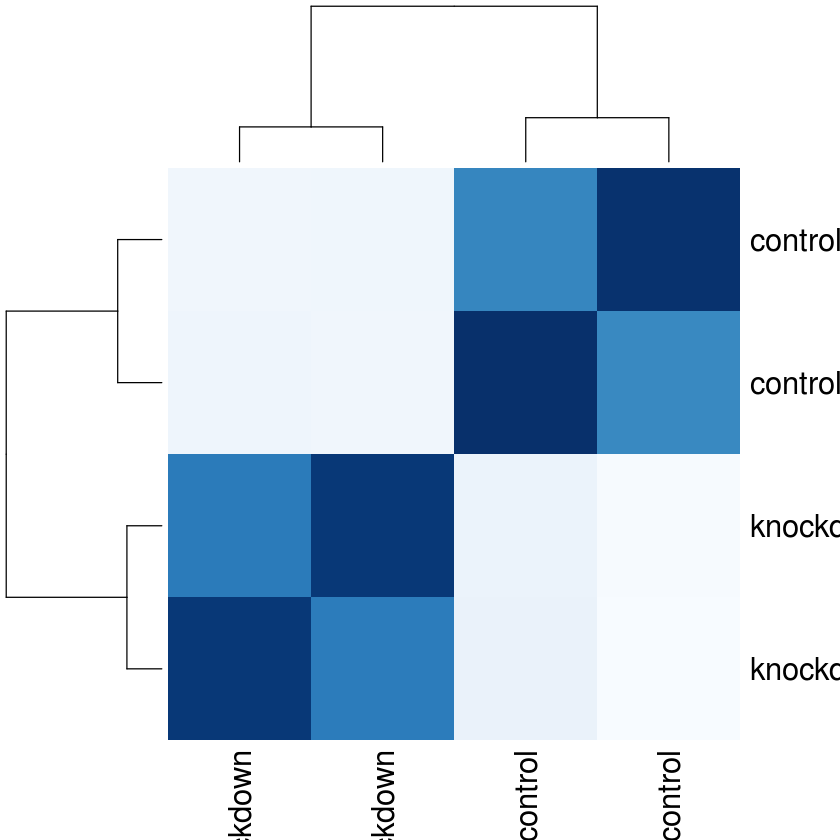

In [21]:

sampleDists <- dist(t(assay(rld)))


sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(rld$condition)

colnames(sampleDistMatrix) <- paste(rld$condition)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

heatmap(sampleDistMatrix,
clustering_distance_rows=sampleDists,
clustering_distance_cols=sampleDists,
col=colors)